## Replication of Grokking experiments 
(checking the relation between attention logits)

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from torch import nn

In [4]:
#torch.tensor(math.sin(math.exp(2*i*math.log(10,000)/128)))

In [5]:
pe = torch.zeros([3, 128])
for j in range(3):
    for i in range(0, 128, 2):
        div_term = math.exp(-(math.log(10000.0) * i) / 128)
        pe[j, i] = math.sin(j * div_term)
        pe[j, i + 1] = math.cos(j * div_term)

In [6]:
class embeddings(nn.Module):
    def __init__(self, vocab_size:int = 114, d :int = 128):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d)

    def forward(self, vocab: list, pe):
        te = self.token_emb(vocab)
        return te+pe.to(te.dtype)

In [7]:
a = torch.tensor(np.arange(0,113))
b = a
e = torch.ones(12769)*113
e = e.unsqueeze(1)
X = torch.concatenate([torch.cartesian_prod(a, b), e],1)
X = X.long()

In [8]:
dataset_y = (X[:, 0] + X[:,1])%113
y = dataset_y

In [9]:
indices = torch.randperm(len(X))

train_size = int(0.3*len(X))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

train_inputs, train_targets = X[train_idx], y[train_idx]
test_inputs,  test_targets  = X[test_idx],  y[test_idx]

In [10]:
class AttentionModule(nn.Module):
    def __init__(self, d_k = 128, h = 4):
        super().__init__()
        self.query_v1 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v1 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v1 = nn.Parameter(torch.randn(128,d_k//h))

        self.query_v2 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v2 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v2 = nn.Parameter(torch.randn(128,d_k//h))

        self.query_v3 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v3 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v3 = nn.Parameter(torch.randn(128,d_k//h))

        self.query_v4 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v4 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v4 = nn.Parameter(torch.randn(128,d_k//h))

    def forward(self, x):
        Q1 = x @ self.query_v1
        K1 = x @ self.key_v1
        V1 = x @ self.value_v1

        Q2 = x @ self.query_v2
        K2 = x @ self.key_v2
        V2 = x @ self.value_v2
        
        Q3 = x @ self.query_v3
        K3 = x @ self.key_v3
        V3 = x @ self.value_v3

        Q4 = x @ self.query_v4
        K4 = x @ self.key_v4
        V4 = x @ self.value_v4



        att1 = Q1@K1.transpose(-2, -1)/ math.sqrt(32)
        att2 = Q2@K2.transpose(-2, -1)/ math.sqrt(32)
        att3 = Q3@K3.transpose(-2, -1)/ math.sqrt(32)
        att4 = Q4@K4.transpose(-2, -1)/ math.sqrt(32)

        att_soft1 = torch.softmax(att1, dim = -1)
        att_soft2 = torch.softmax(att2, dim = -1)
        att_soft3 = torch.softmax(att3, dim = -1)
        att_soft4 = torch.softmax(att4, dim = -1)

        out1 = att_soft1 @ V1
        out2 = att_soft2 @ V2
        out3 = att_soft3 @ V3
        out4 = att_soft4 @ V4
        out = torch.cat([out1, out2, out3, out4],-1)
        return [att1, att2, att3, att4], out

In [11]:
class ModelArchitecture(nn.Module):
    def __init__(self, n :int, d_k: int, attention: AttentionModule, embedding: embeddings):
        super().__init__()
        self.attention = attention
        self.embedding = embedding
        self.mlp = nn.Sequential(
            nn.Linear(d_k, n),
            nn.ReLU(),
            nn.Linear(n, d_k)
        )
        self.unembed = nn.Linear(d_k, 114, bias = False)

    def forward(self, x):
        att, out = self.attention(self.embedding(x, pe))
        output = self.mlp(out)
        logits = self.unembed(output)
        return att, logits

        

In [ ]:
epochs = 100000

attention = AttentionModule()
embedding = embeddings()
model = ModelArchitecture(n = 512, d_k = 128, attention = attention, embedding = embedding)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 1)#0.3, 0.5, 1, 3, 5, 8
criterion = nn.CrossEntropyLoss()

In [13]:

values = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    att, logits = model(train_inputs)
    predicted = logits[:, 2, :]
    loss = criterion(predicted, train_targets)
    train_acc = (predicted.argmax(-1) == train_targets).float().mean()

    loss.backward()
    optimizer.step()

    if epoch%100==0:
        model.eval()
        with torch.no_grad():
            att_test, test_logits = model(test_inputs)
            test_predicted = test_logits[:, 2, :]

            test_loss = criterion(test_predicted, test_targets)
            test_acc = (test_predicted.argmax(-1) == test_targets).float().mean()

        temp = {
            "train_att": att,
            "test_att": att_test,
            "train_loss": loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        }
        o = f"| Epoch: {epoch} | Train Accuracy: {train_acc} | Train Loss: {loss} | Test Accuracy: {test_acc} | Test Loss: {test_loss} |"
        print(o)
        if epoch%500==0:
            values.append(temp)
        with open('epoch_results_logging.log', 'a') as f:
            f.write(f"{o}\n")
        

| Epoch: 0 | Train Accuracy: 0.008877284824848175 | Train Loss: 6.2430100440979 | Test Accuracy: 0.0063765523955225945 | Test Loss: 5.719315528869629 |
| Epoch: 100 | Train Accuracy: 0.365013062953949 | Train Loss: 2.450683116912842 | Test Accuracy: 0.07271506637334824 | Test Loss: 7.090970516204834 |
| Epoch: 200 | Train Accuracy: 0.38172322511672974 | Train Loss: 2.052001476287842 | Test Accuracy: 0.07763732224702835 | Test Loss: 9.021623611450195 |
| Epoch: 300 | Train Accuracy: 0.3932114839553833 | Train Loss: 1.9430947303771973 | Test Accuracy: 0.06879964470863342 | Test Loss: 9.549296379089355 |
| Epoch: 400 | Train Accuracy: 0.41201043128967285 | Train Loss: 1.8518495559692383 | Test Accuracy: 0.06633851677179337 | Test Loss: 9.602267265319824 |
| Epoch: 500 | Train Accuracy: 0.44569191336631775 | Train Loss: 1.7375942468643188 | Test Accuracy: 0.06231122091412544 | Test Loss: 9.806052207946777 |
| Epoch: 600 | Train Accuracy: 0.5436031222343445 | Train Loss: 1.4094748497009277 

In [14]:
torch.save(model.state_dict(), 'model_weights.pth')

In [17]:
import json
def tensor_handler(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu().tolist()

with open("results_1.json", 'w') as f:
    json.dump(values, f, indent=4, default=tensor_handler)

In [18]:
attention = AttentionModule()
embedding = embeddings()
model = ModelArchitecture(n=512, d_k=128, attention=attention, embedding=embedding)

model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

ModelArchitecture(
  (attention): AttentionModule()
  (embedding): embeddings(
    (token_emb): Embedding(114, 128)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (unembed): Linear(in_features=128, out_features=114, bias=False)
)

In [21]:
a_val = 3
b_range = torch.arange(113)
equals_token = torch.tensor([113] * 113)
a_fixed = torch.tensor([a_val] * 113)

input_data = torch.stack([a_fixed, b_range, equals_token], dim=1).long()

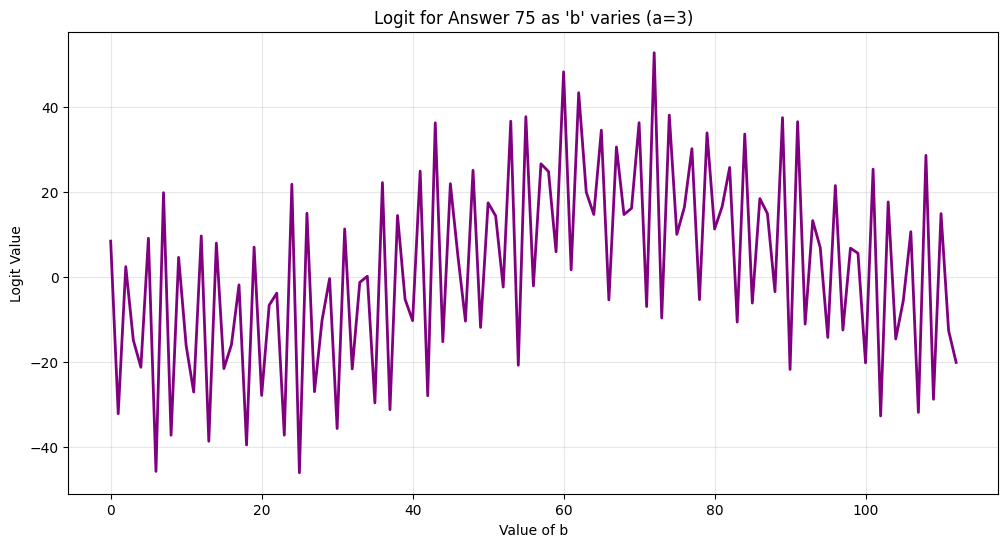

In [22]:
with torch.no_grad():
    _, logits = model(input_data)
    answer_to_track = 75 
    curves = logits[:, 2, answer_to_track].numpy()

# Plotting the curve
plt.figure(figsize=(12, 6))
plt.plot(b_range.numpy(), curves, color='purple', linewidth=2)
plt.title(f"Logit for Answer {answer_to_track} as 'b' varies (a={a_val})")
plt.xlabel("Value of b")
plt.ylabel("Logit Value")
plt.grid(True, alpha=0.3)
plt.savefig(f'grokking_pattern_observed.png', dpi=300)
plt.show()